In [1]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

In [2]:
DATA_DIR = 'C:/Users/JLK/Downloads/free-spoken-digit-dataset-master/recordings/'
#DATA_DIR = 'C:/Users/JLK/requirements/recordings/'

In [3]:
test_speaker = 'theo'
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a, i: a[:, 0: i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0],i - a.shape[1]))))
#STFT한 것, CNN분석하기 위해 Spectogram으로 만든 것, MF한 것, mel-spectogram한 것


for fname in os.listdir(DATA_DIR):
    try:
        if '.wav' not in fname or 'dima' in fname:
            continue
        struct = fname.split('_')
        digit = struct[0]
        speaker = struct[1]
        wav, sr = librosa.load(DATA_DIR + fname)
        padded_x = pad1d(wav, 30000)
        spectrogram = np.abs(librosa.stft(wav))
        padded_spectogram = pad2d(spectrogram, 40)
        
        mel_spectogram = librosa.feature.melspectrogram(wav)
        padded_mel_spectrogram = pad2d(mel_spectogram, 40)
        
        mfcc = librosa.feature.mfcc(wav)
        padded_mfcc = pad2d(mfcc, 40)
        
        if speaker == test_speaker:
            test_X.append(padded_x)
            test_spectrograms.append(padded_spectogram)
            test_mel_spectrograms.append(padded_mel_spectrogram)
            test_mfccs.append(padded_mfcc)
            test_y.append(digit)
        else:
            train_X.append(padded_x)
            train_spectrograms.append(padded_spectogram)
            train_mel_spectrograms.append(padded_mel_spectrogram)
            train_mfccs.append(padded_mfcc)
            train_y.append(digit)
    except Exception as e:
        print(fname, e)
        raise
        
train_X = np.vstack(train_X)
train_spectrograms = np.array(train_spectrograms)
train_mel_spectrograms = np.array(train_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_spectrograms = np.array(test_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_X:', train_X.shape)
print('train_spectrograms:', train_spectrograms.shape)
print('train_mel_spectrograms', train_mel_spectrograms.shape)
print('train_mfccs', train_mfccs.shape)
print('train_y', train_y.shape)

print('test_X', test_X.shape)
print('test_spectrograms', test_spectrograms.shape)
print('test_mel_spectrograms', test_mel_spectrograms.shape)
print('test_mfccs', test_mfccs.shape)
print('test_y', test_y.shape)

train_X: (2500, 30000)
train_spectrograms: (2500, 1025, 40)
train_mel_spectrograms (2500, 128, 40)
train_mfccs (2500, 20, 40)
train_y (2500, 10)
test_X (500, 30000)
test_spectrograms (500, 1025, 40)
test_mel_spectrograms (500, 128, 40)
test_mfccs (500, 20, 40)
test_y (500, 10)


In [4]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (2500, 20, 40, 1)
test X shape: (500, 20, 40, 1)


In [5]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(10, activation='softmax')(m)

model = Model(ip, op)

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 40, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                73760     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 75,178
Trainable params: 75,178
Non-trainable params: 0
__________________________________________________

In [6]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 3.9225 - accuracy: 0.1148 - val_loss: 2.2927 - val_accuracy: 0.1180
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 2.2843 - accuracy: 0.1212 - val_loss: 2.2724 - val_accuracy: 0.1200
Epoch 3/100
79/79 [==============================] - 0s 6ms/step - loss: 2.2806 - accuracy: 0.1280 - val_loss: 2.2753 - val_accuracy: 0.1280
Epoch 4/100
79/79 [==============================] - 0s 6ms/step - loss: 2.2347 - accuracy: 0.1332 - val_loss: 2.1582 - val_accuracy: 0.1200
Epoch 5/100
79/79 [==============================] - 0s 6ms/step - loss: 2.1504 - accuracy: 0.1636 - val_loss: 2.0565 - val_accuracy: 0.1520
Epoch 6/100
79/79 [==============================] - 0s 6ms/step - loss: 2.0811 - accuracy: 0.1812 - val_loss: 2.0881 - val_accuracy: 0.1420
Epoch 7/100
79/79 [==============================] - 0s 6ms/step - loss: 2.0250 - accuracy: 0.1984 - val_loss: 1.9884 - val_accuracy: 0.1680
Epoch 8/100
7

Epoch 59/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6297 - accuracy: 0.7592 - val_loss: 2.0186 - val_accuracy: 0.5600
Epoch 60/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6176 - accuracy: 0.7588 - val_loss: 2.0186 - val_accuracy: 0.5600
Epoch 61/100
79/79 [==============================] - 0s 6ms/step - loss: 0.5897 - accuracy: 0.7740 - val_loss: 2.2015 - val_accuracy: 0.5300
Epoch 62/100
79/79 [==============================] - 0s 6ms/step - loss: 0.5850 - accuracy: 0.7700 - val_loss: 1.6634 - val_accuracy: 0.5680
Epoch 63/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6186 - accuracy: 0.7532 - val_loss: 1.9680 - val_accuracy: 0.5360
Epoch 64/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6479 - accuracy: 0.7364 - val_loss: 2.0467 - val_accuracy: 0.5400
Epoch 65/100
79/79 [==============================] - 0s 6ms/step - loss: 0.5685 - accuracy: 0.7740 - val_loss: 1.9690 - val_accuracy: 0.5940
Epoch 

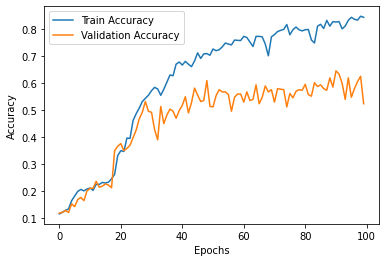

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)


m=Flatten()(m)
m=Dense(32, activation='relu')(m)
op=Dense(10, activation='softmax')(m)

model2 = Model(ip, op)

model2.summary()


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 40, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                73760     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 75,178
Trainable params: 75,178
Non-trainable params: 0
__________________________________________________